## Implemenetation of Neumann and Ddirichlet conditions
Author: Jørgen S. Dokken
As in the previous example, we define our mesh,function space and bilinear form $a(u,v)$.

In [1]:
import dolfinx
import numpy as np
import ufl

from mpi4py import MPI
from petsc4py import PETSc

mesh = dolfinx.UnitSquareMesh(MPI.COMM_WORLD, 10, 10)
V = dolfinx.FunctionSpace(mesh, ("CG", 1))
u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
a = ufl.dot(ufl.grad(u), ufl.grad(v))*ufl.dx

Now we get to the Neumann and Dirichlet boundary condition. As previously, we use a Python-function to define the boundary where we should have a Dirichlet condition. Then, with this function, we locate degrees of freedom that fullfils this condition. 

In [2]:
def u_exact(x):
    return 1 + x[0]**2 + 2*x[1]**2

def boundary_D(x):
    return np.logical_or(np.isclose(x[0], 0), np.isclose(x[0],1))
dofs_D = dolfinx.fem.locate_dofs_geometrical(V, boundary_D)
u_bc = dolfinx.Function(V)
u_bc.interpolate(u_exact)
u_bc.vector.ghostUpdate(PETSc.InsertMode.INSERT_VALUES, PETSc.ScatterMode.FORWARD)
bc = dolfinx.DirichletBC(u_bc, dofs_D)

The next step is to define the Neumann condition. We first define $g$ uses `UFL`s `SpatialCoordinate`-function, and then in turn create a boundary integration measure `ds`. As the test function $v$ is zero on the boundary integrals over the Dirichlet boundary dissapears, and wee can integrate `g*v*ds` over the entire boundary.

In [3]:
x = ufl.SpatialCoordinate(mesh)
g = -4 * x[1]
f = dolfinx.Constant(mesh, -6)
L = f * v * ufl.dx - g * v * ufl.ds

We can now assemble and solve the linear system of equations 

Error_L2 = 5.27e-03
Error_max = 7.21e-06


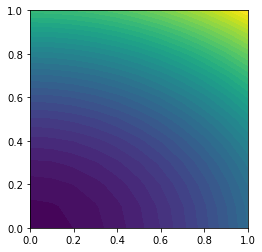

In [4]:
A = dolfinx.fem.assemble_matrix(a, bcs=[bc])
A.assemble()
b = dolfinx.fem.assemble_vector(L)
dolfinx.fem.apply_lifting(b, [a], [[bc]])
b.ghostUpdate(addv=PETSc.InsertMode.ADD_VALUES,mode=PETSc.ScatterMode.REVERSE)
dolfinx.fem.set_bc(b, [bc])

uh = dolfinx.Function(V)
solver = PETSc.KSP().create(MPI.COMM_WORLD)
solver.setType(PETSc.KSP.Type.PREONLY)
solver.getPC().setType(PETSc.PC.Type.LU)
solver.setOperators(A)
solver.solve(b, uh.vector)
uh.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT_VALUES,mode=PETSc.ScatterMode.FORWARD)

import dolfinx.plotting
dolfinx.plotting.plot(uh)

V2 = dolfinx.FunctionSpace(mesh, ("CG", 2))
uex = dolfinx.Function(V2)
uex.interpolate(u_exact)
uex.vector.ghostUpdate(addv=PETSc.InsertMode.INSERT, mode=PETSc.ScatterMode.FORWARD)
error_L2 = dolfinx.fem.assemble_scalar((uh - uex)**2 * ufl.dx)
error_L2 = np.sqrt(MPI.COMM_WORLD.allreduce(error_L2, op=MPI.SUM))

u_vertex_values = uh.compute_point_values()
u_ex_vertex_values = uex.compute_point_values()
error_max = np.max(np.abs(u_vertex_values - u_ex_vertex_values))
error_max = MPI.COMM_WORLD.allreduce(error_max, op=MPI.MAX)
print("Error_L2 = {0:.2e}".format(error_L2))
print("Error_max = {0:.2e}".format(error_max))